Initial EDA

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
df = pd.read_json('AMAZON_FASHION.json', lines=True)

In [10]:
meta_data = pd.read_json('meta_AMAZON_FASHION.json', lines=True)

In [29]:
df.head()
#df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


In [83]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186637 entries, 0 to 186636
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            186632 non-null  object
 1   brand            139957 non-null  object
 2   feature          123875 non-null  object
 3   rank             180222 non-null  object
 4   date             185001 non-null  object
 5   asin             186637 non-null  object
 6   imageURL         132017 non-null  object
 7   imageURLHighRes  132017 non-null  object
 8   description      15869 non-null   object
 9   price            17799 non-null   object
 10  also_view        11595 non-null   object
 11  also_buy         21642 non-null   object
 12  fit              4831 non-null    object
 13  details          885 non-null     object
 14  similar_item     317 non-null     object
 15  tech1            97 non-null      object
dtypes: object(16)
memory usage: 22.8+ MB


We see some null values in reviername, review text, summary, vote, style, and image
We expect these nulls to be lack of reviewer input
Null values in the vote are due to no votes on the helpfulness of a review

In [30]:
len(df["asin"].unique())

#186189 unique asin numbers - 883636 different entries, so duplicates of a product are to be expected

186189

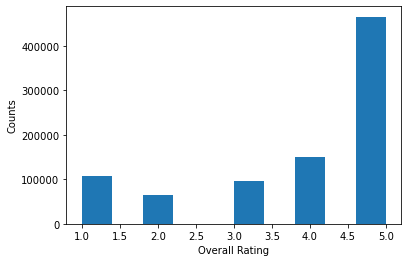

In [34]:
plt.hist(df['overall'])
plt.xlabel("Overall Rating")
plt.ylabel("Counts")
plt.show()

Text(0.5, 1.0, 'Number of Reviews for Top 20 Products')

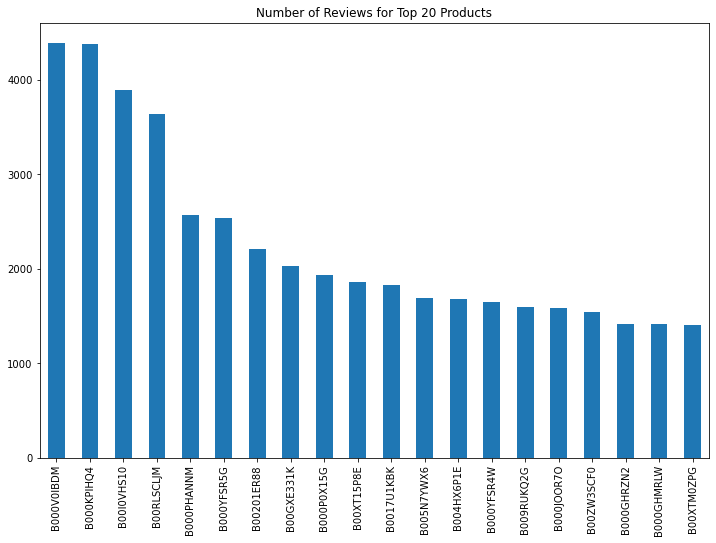

In [60]:
most_pop_prodcts = df['asin'].value_counts()
plt.figure(figsize=(12,8))
most_pop_prodcts[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Products")

Text(0.5, 1.0, 'Distribution of Review Length')

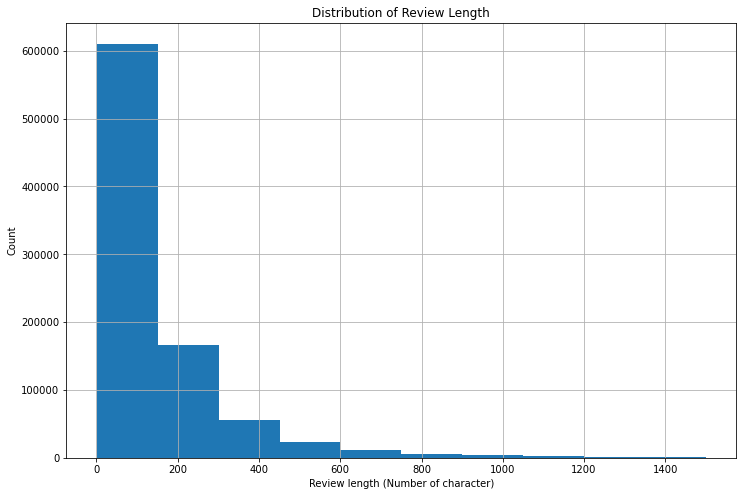

In [11]:
review_length = df["reviewText"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')
plt.title("Distribution of Review Length")

Cleaning

In [21]:
df_clean = df.dropna(subset=["reviewText"])

##removing rows that have no reviewText - reviewer did not leave a response

In [80]:
len(df_clean)

882403

In [174]:
total = (df_clean['asin'].value_counts()[:500]).to_frame()
total.reset_index(inplace=True)
counts = total.rename(columns={"index": "asin", 'asin': "total reviews"})
counts

,asin,total reviews
0,B000V0IBDM,4380
1,B000KPIHQ4,4371
2,B00I0VHS10,3884
3,B00RLSCLJM,3633
4,B000PHANNM,2566
...,...,...
495,B00MMEN7MK,144
496,B00J8H9NJK,144
497,B00CN5B8UG,143
498,B0183JVBA2,143


In [175]:
counts.merge(df_clean, on='asin', how='left')

avg = counts.merge(df_clean, on='asin', how='left')
avg = avg.groupby('asin')["overall"].mean().to_frame()

,total reviews,overall
total reviews,1.00000,0.16344
overall,0.16344,1.00000


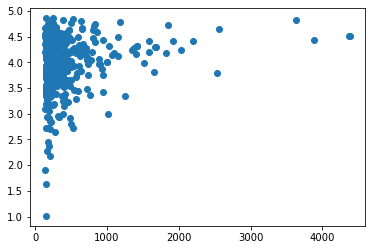

In [176]:
table = counts.merge(avg, on='asin')
table

plt.scatter('total reviews', 'overall', data=table)
table.corr()

NLP - Analysis

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

In [74]:
df_clean['overall'].value_counts()

5    464591
4    149169
1    106984
3     96969
2     64690
Name: overall, dtype: int64

In [76]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(df_clean, df_clean["overall"]): 
    strat_train = df_clean.reindex(train_index)
    strat_test = df_clean.reindex(test_index)

In [79]:
len(strat_train), len(strat_test)

(705922, 176481)

Sentiment Analysis


In [38]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('/Documents/SentiStrength.jar')
senti.setSentiStrengthLanguageFolderPath('C:/Documents/SentiStrengthData/') # Note: Provide absolute path instead of relative path


In [41]:
string = df_clean['reviewText'][0]

In [3]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"
# Add sentiments to the data
# strat_train["Sentiment"] = strat_train["overall"].apply(sentiments)
# strat_test["Sentiment"] = strat_test["overall"].apply(sentiments)
# strat_train["Sentiment"][:20]

In [6]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinegao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christinegao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [160]:
X_train = strat_train["reviewText"]
X_train_targetSentiment = strat_train["Sentiment"]
X_test = strat_test["reviewText"]
X_test_targetSentiment = strat_test["Sentiment"]
print(len(X_train), len(X_test))

705922 176481


In [161]:
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
X_train_targetSentiment = X_train_targetSentiment.fillna(' ')
X_test_targetSentiment = X_test_targetSentiment.fillna(' ')

# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
X_train_counts.shape

(705922, 75843)

In [27]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [26]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names

def NaiveBayes_Model(Train_Set,Test_Set):
    classifier = NaiveBayesClassifier.train(Train_Set) 
    Important10 = classifier.show_most_informative_features(10)
    accuracy = nltk.classify.accuracy(classifier, Test_Set)*100
    return classifier,Important10,accuracy

In [9]:
sentence = df.loc[:,"reviewText"]
example = sentence[2]

In [4]:
# nltk.pos_tag(word_tokenize(example))
